In [1]:
import rootpath
import sys
sys.path.append(rootpath.detect())

import matplotlib.pyplot as plt
import numpy as np
from testsuite.surrogates import GP, MultiSurrogate
from testsuite.utilities import Pareto_split

In [2]:
seed = 1
INVERT = True
uncertainty= 0.1

In [ ]:
def get_ys(n_obj, n_p):
    found = False
    n_samples = n_p
    sig = 2
    
    theta=np.pi/4
    R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    
    while found == False:
        xp = np.random.multivariate_normal(np.zeros(n_obj), np.diag(np.ones(n_obj)*sig), size=n_p*8)
        pi, di = Pareto_split(xp, return_indices=True)
        print(sig, sum(pi))
        if sum(pi)==n_p:
            return xp, pi, di
        elif sum(pi)<n_p:
            pass
#             sig +=1
        elif sum(pi)>n_p and n_samples>0:
            pass
#             sig -=1

In [4]:
def image_infill(opt, front_value = 0., n_contours=20):
    #figure_properties
    fig = plt.figure(figsize=[9,7])
    ax = fig.gca()
    l_lims = opt.apply_weighting(np.array([[0, 0]]))
    u_lims = opt.apply_weighting(np.array([[1.5, 1.5]]))
    ax.set_xlim([0., 1.5])
    ax.set_ylim([0., 1.5])
    
    # compute infill
    M, N = 200, 200
    x = np.linspace(0., 1.5, M)
    y = np.linspace(0., 1.5, N)
    xx, yy = np.meshgrid(x, y)
    xy = np.vstack((xx.flat, yy.flat)).T
    xyw = opt.apply_weighting(xy)
    zz = np.array([opt._scalarise_y(xyi, np.ones_like(xyi)*uncertainty*opt.obj_weights, invert=INVERT) for xyi in xyw])
    zz = zz.reshape(N,M)
    
    #image infill
    pcol = ax.pcolor(xx, yy, zz)
    levels = np.linspace(zz.min(), zz.max(), n_contours+2)[1:-1]
    ax.contour(xx, yy, zz, colors="white", levels=levels)
    if front_value is not None:
        ax.contour(xx, yy, zz, colors="C3", levels=[front_value])
        front_legend = plt.Line2D([0], [0], c="C3")
    
    # scatter samples
    ax.scatter(opt.d[:,0], opt.d[:,1], facecolors='none', edgecolors="C3", linewidth=2., label="dominated samples")
    ax.scatter(opt.p[:,0], opt.p[:,1], c="C3", label="non-dominated samples")
    fig.colorbar(pcol)
    handles, labels = ax.get_legend_handles_labels()
    handles.append(front_legend)
    labels.append("{}".format(front_value))
    ax.legend(handles, labels)
    
    return fig

In [5]:
import time

In [ ]:
y, pi, di = get_ys(n_obj =6, n_p=60)
# plt.scatter(*y[pi].T, c="C3", s=5)
# plt.scatter(*y[di].T, c="C0", s=5)
# print(sum(pi), " pareto \t ", sum(di), "dominated")

 <ipython-input-4-5d45382aaf80>:21: MatplotlibDeprecationWarning:shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
 <ipython-input-4-5d45382aaf80>:25: UserWarning:No contour levels were found within the data range.


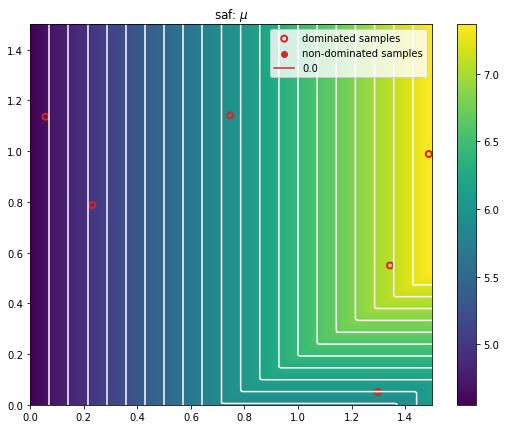

In [28]:
from testsuite.optimisers import Saf

saf_opt = Saf(objective_function=lambda x: x[0:2], ei=False,  limits=[[0, 0, 0, 0, 0], [1,1,1,1,1]], surrogate=MultiSurrogate(GP), n_initial=10, seed=seed)
# saf_opt.obj_weights = np.ones_like(saf_opt.obj_weights)
saf_opt.x = np.random.randn(y.shape[0], 5)
saf_opt.y = y
saf_opt.p = y[pi]
saf_opt.d = y[di]

fig_saf = image_infill(saf_opt)
fig_saf.axes[0].set_title("saf: $\mu$");
fig_saf.axes[0].scatter((saf_opt.y*saf_opt.obj_weights)[:,0], (saf_opt.y*saf_opt.obj_weights)[:,1], c="magenta")

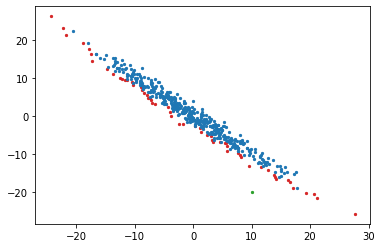

In [42]:
plt.scatter(*saf_opt.p.T, c="C3", s=5)
plt.scatter(*saf_opt.d.T, c="C0", s=5)
q = np.array([10, -20, 1., 1., 1.]).reshape(1,-1)

plt.scatter(*q[0, :2].T, c="C2", s=5)

In [46]:
saf_opt.x.shape

(480, 5)

In [47]:
q.shape

(1, 5)

In [49]:
%%time

saf_opt.get_next_x()

reconstraining parameters GP_regression.Mat52.lengthscale
reconstraining parameters GP_regression.Mat52.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/10, f = 681.0904966951944
Optimization restart 2/10, f = 23973702.20428837
Optimization restart 3/10, f = 3204.1950075311206
Optimization restart 4/10, f = 681.0904959382428
Optimization restart 5/10, f = 3204.1950075311206
Optimization restart 6/10, f = 681.0904959382513
Optimization restart 7/10, f = 23973702.20428837
Optimization restart 8/10, f = 23710228000.528404
Optimization restart 9/10, f = 23652757724.205982
Optimization restart 10/10, f = 3204.1950075311206


reconstraining parameters GP_regression.Mat52.lengthscale
reconstraining parameters GP_regression.Mat52.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/10, f = 681.0904966873651
Optimization restart 2/10, f = 23455581936.896145
Optimization restart 3/10, f = 681.0904959382435
Optimization restart 4/10, f = 681.0904959382428
Optimization restart 5/10, f = 23568864498.862415
Optimization restart 6/10, f = 23973702.204288375
Optimization restart 7/10, f = 3204.1950075311206
Optimization restart 8/10, f = 3204.1950075311206
Optimization restart 9/10, f = 3204.1950075311206
Optimization restart 10/10, f = 681.090495938243
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=134793, Sat Jan 30 22:43:53 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 3.713047307277437e+00 1.0e+00 2.24e-01  2e-01  2e-01 0:00.0
termination on tolfun=1e-11 (Sat Jan 30 22:43:53 2021)
final/bestever f-value = 3.713047e+00 3.713047e+00
incumbent solution: [0.016079804513939405, 0.37991376691100454, 0.24142975888104418, 0.3434174661288245, 0.47321732628270086]
std deviation: [0.2299784370085496, 0

 /home/finley/miniconda3/envs/testsuite/lib/python3.8/site-packages/cma/utilities/utils.py:329: UserWarning:flat fitness (f=3.713047, sigma=2.24e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately. (iteration=1)


array([[0.00331337, 0.34652707, 0.48893028, 0.36996351, 0.50684373]])

 <ipython-input-4-5d45382aaf80>:21: MatplotlibDeprecationWarning:shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
 <ipython-input-4-5d45382aaf80>:25: UserWarning:No contour levels were found within the data range.


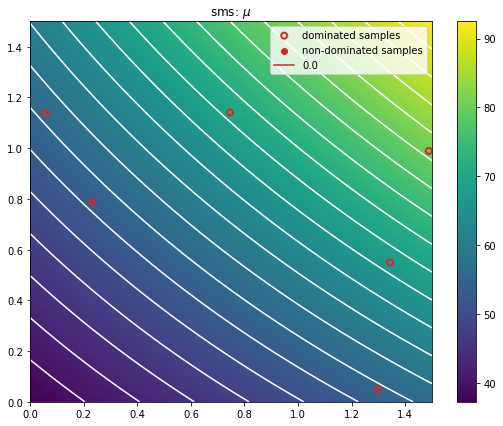

In [50]:
from testsuite.optimisers import SmsEgo

sms_opt = SmsEgo(objective_function=lambda x: x[0:2], ei=False,  limits=[[0, 0, 0, 0, 0], [1,1,1,1,1]], surrogate=MultiSurrogate(GP), n_initial=10, seed=seed)
# sms_opt.obj_weights = np.ones_like(sms_opt.obj_weights)
sms_opt.x = np.random.randn(y.shape[0], 5)
sms_opt.y = y
sms_opt.p = y[pi]
sms_opt.d = y[di]

fig_sms = image_infill(sms_opt)
fig_sms.axes[0].set_title("sms: $\mu$");
fig_sms.axes[0].scatter((sms_opt.y*sms_opt.obj_weights)[:,0], (sms_opt.y*sms_opt.obj_weights)[:,1], c="magenta")

In [51]:
%%time

sms_opt.get_next_x()

reconstraining parameters GP_regression.Mat52.lengthscale
reconstraining parameters GP_regression.Mat52.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/10, f = 681.0904966951944
Optimization restart 2/10, f = 23973702.20428837
Optimization restart 3/10, f = 3204.1950075311206
Optimization restart 4/10, f = 681.0904959382428
Optimization restart 5/10, f = 3204.1950075311206
Optimization restart 6/10, f = 681.0904959382513
Optimization restart 7/10, f = 23973702.20428837
Optimization restart 8/10, f = 23710228000.528404
Optimization restart 9/10, f = 23652757724.205982
Optimization restart 10/10, f = 3204.1950075311206


reconstraining parameters GP_regression.Mat52.lengthscale
reconstraining parameters GP_regression.Mat52.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/10, f = 681.0904966873651
Optimization restart 2/10, f = 23455581936.896145
Optimization restart 3/10, f = 681.0904959382435
Optimization restart 4/10, f = 681.0904959382428
Optimization restart 5/10, f = 23568864498.862415
Optimization restart 6/10, f = 23973702.204288375
Optimization restart 7/10, f = 3204.1950075311206
Optimization restart 8/10, f = 3204.1950075311206
Optimization restart 9/10, f = 3204.1950075311206
Optimization restart 10/10, f = 681.090495938243
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=94882, Sat Jan 30 22:48:34 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 3.701838354988904e+01 1.0e+00 2.23e-01  2e-01  2e-01 0:00.1
termination on tolfun=1e-11 (Sat Jan 30 22:48:34 2021)
final/bestever f-value = 3.701838e+01 3.701838e+01
incumbent solution: [0.24663996508801472, 0.3665642454000802, 0.23924774133724747, 0.3175975990859613, 0.5583440880355367]
std deviation: [0.2074351363300287, 0.228

 /home/finley/miniconda3/envs/testsuite/lib/python3.8/site-packages/cma/utilities/utils.py:329: UserWarning:flat fitness (f=37.018384, sigma=2.23e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately. (iteration=1)


array([[0.45184405, 0.11778306, 0.34456467, 0.22020361, 0.55520106]])